In [3]:
import os, json, IPython
project_name = "house-prices-advanced-regression-techniques"
token = {"username":"santanukundu","key":"de462df622bbe0817a45f17f3c1373eb"}
os.environ['KAGGLE_CONFIG_DIR']='.'
with open('kaggle.json', "w") as f:
    json.dump(token, f)
!chmod 600 ./kaggle.json
!kaggle competitions download -c $project_name
project_name += ".zip"
!unzip $project_name && rm $project_name

## Those libraries need to be used
!pip install catboost xgboost
## Clear the cell
IPython.display.clear_output()

In [32]:
!cat data_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [57]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor


from catboost import CatBoostRegressor

model_params ={
    'Ridge' : {
            'alpha' : [.01, .1, 1.0, 10.0, 100.0],
            'tol'   : [ 0.00001,0.0001, 0.001, 0.1,1],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
      'random_state': [None,42]
        },
 'SVR'  : {
      'kernel'      : [ 'linear', 'poly', 'rbf', 'sigmoid'],
      'degree'      : [2, 3, 4 , 5, 6],
      'gamma'       : ['scale', 'auto'],
      'tol'         : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
      'epsilon'     : [.1, .3, .5, .7, .9],
      'C'           : [.01, .1, 1, 10],
        },
 'GBR' : {
      'loss'        : [ 'squared_error', 'huber'],
    'learning_rate' : [ 0.01, .05],
      'n_estimators': [ 500, 800],
      'max_features': ['sqrt', 10, 13, 15],
      'max_depth'   : [3, 4, 5],
    #   'alpha'       : [.1, .5, .9],
      'random_state': [42],

    }
}

class HousePricePrediction():

    def __init__(self):
        # Basic config
        self.train = pd.read_csv('train.csv')
        self.test = pd.read_csv('test.csv')
        self.numerical_features   = list(self.train.select_dtypes(exclude='object').columns)
        self.categorical_features = list(self.train.select_dtypes(include='object').columns)
        self.dropping_cols = [
        # Redundant cols
            'Id',
        # Feature those might cause multi-collinearity
            'TotalBsmtSF', 'GrLivArea','GarageCars', 'GarageYrBlt',
            'TotRmsAbvGrd',
        # Feature having more than .95% one value or highly Imbalanced feature
            'Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating',
        # Feature having more data absent (please verify carefully)

                ]
        self.target = 'SalePrice'

        # Training test split
        self.test_size = 0.2

        # Choosing Model

        # self.model = Ridge()
        self.model = GradientBoostingRegressor(learning_rate= 0.05, loss= 'squared_error', max_depth= 4, max_features= 'sqrt', n_estimators= 800, random_state= 42)
        # self.model = CatBoostRegressor(loss_function='RMSE', verbose = 0)



        # GridSearchCV parameters
        self.model_class = GradientBoostingRegressor()
        self.isGrid = True
        self.cv = 5
        self.params = model_params['GBR']

        # For prediction and saving data
        self.predicted_data = pd.DataFrame()
        self.saved_file_name = 'output.csv'

        # Start training your model
        self.pipeline()

    """
    preprocessing includes
    1. categorical to numerical conversion
    """
    def preprocess(self, df):
        calc_cols = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
        for i in calc_cols:
            df[i] = df['YrSold'] - df[i]

        df['YrSold'] = 2023 - df['YrSold']

        df['Miley'] = ((df['Alley'].notna()) | (df['MiscFeature'].notna())).astype(int)
        # Dropping 'Alley' and 'MiscFeature'
        df.drop(columns=['Alley', 'MiscFeature'], inplace=True)
        df['LotFrontage'].fillna(df['LotFrontage'].median(), inplace=True)


        df.drop(['GarageType', 'GarageFinish', 'GarageCond'], axis=1, inplace=True)

        # Fill missing values in 'GarageQual' with 'None'
        df['GarageQual'].fillna('None', inplace=True)

        df.drop(['BsmtFinType2', 'BsmtExposure', 'BsmtCond', 'BsmtFinType1'], axis=1, inplace=True)

        # Fill missing values in 'GarageQual' with 'None'
        df['BsmtQual'].fillna('None', inplace=True)

        # Fill missing values in 'MasVnrType' with 'None'
        df['MasVnrType'].fillna('None', inplace=True)
        # Fill missing values in 'MasVnrArea' with 0
        df['MasVnrArea'].fillna(0, inplace=True)

        # filling na values
        # numerical cols will be filled with 0
        # categorical ones will be filled with 'Not present'
        self.mapper_na_to_val = dict()
        for i in self.numerical_features:
            self.mapper_na_to_val[i] = 0
        for i in self.categorical_features:
            self.mapper_na_to_val[i]='None'

        df = df.fillna(value= self.mapper_na_to_val)
        self.numerical_features   = list(df.select_dtypes(exclude='object').columns)
        self.categorical_features = list(df.select_dtypes(include='object').columns)
        return df

    def encoding(self,df):
        self.categorical_mapper = {}
        for i in self.categorical_features:
            self.categorical_mapper[i] = dict(df.groupby(i)['SalePrice'].mean())
            df[i] = df.groupby(i)['SalePrice'].transform('mean')
            if 'None' not in self.categorical_mapper[i].keys():
                self.categorical_mapper[i]['None'] = df['SalePrice'].mode()
        return df

    def training(self,df):
        """"
        Drop columns if required
        """
        self.scaler_X, self.scaler_Y = MinMaxScaler(), MinMaxScaler()

        y = df[[self.target]]
        X = df.drop([self.target] + self.dropping_cols ,axis=1)
        self.cols = X.columns

        X, y = self.scaler_X.fit_transform(X), self.scaler_Y.fit_transform(y)

        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=self.test_size, random_state=42)

        # training our model
        if self.isGrid:
                # GridSearchCV
            self.grid_search = GridSearchCV(self.model_class, self.params, cv=self.cv)
            self.grid_search.fit(X_train, y_train.flatten())
            print("Best parameters: ")
            print(self.grid_search.best_params_)
            print("R2 score for training data: ", self.grid_search.score(X_train, y_train.flatten()))
            print("R2 score for testing data: ", self.grid_search.score(X_test, y_test.flatten()))
        else:
            self.model.fit(X_train, y_train.flatten())
            print("R2 score for training data: ", self.model.score(X_train, y_train.flatten()))
            print("R2 score for testing data: ", self.model.score(X_test, y_test.flatten()))
            print("MSE score for training data: ", self.mse_score(self.model.predict(X_train), y_train.flatten()))
            print("MSE score for testing data: ", self.mse_score(self.model.predict(X_test), y_test.flatten()))



    def prediction(self,df):
        x = self.preprocess(df).replace(self.categorical_mapper).drop(self.dropping_cols, axis=1)

        self.predicted_data['Id'] = df['Id']

        if self.isGrid:
            # Grid Search
            self.predicted_data[self.target] = self.scaler_Y.inverse_transform(
            self.grid_search.predict(self.scaler_X.transform(x)).reshape(-1,1)
            )
        else:
            # OneModel
            self.predicted_data[self.target] = self.scaler_Y.inverse_transform(
                self.model.predict(self.scaler_X.transform(x)).reshape(-1,1)
                )
        # Writing data to file
        self.predicted_data.to_csv(self.saved_file_name,index=False)

    def pipeline(self):
        self.training(self.encoding(self.preprocess(self.train)))
        self.prediction(self.test)
    def mse_score(self,X,y):
        return np.mean((X-y)**2)
    def coef_(self):
        return pd.DataFrame(zip(self.cols,self.model.coef_.flatten()), columns= ['feature_name', 'weight']
                    ).sort_values('weight', ascending=False, key= lambda x: abs(x)).reset_index(drop=True)
    def intercept_(self):
        return self.model.intercept_

In [58]:
prediction = HousePricePrediction()

Best parameters: 
{'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 4, 'max_features': 13, 'n_estimators': 800, 'random_state': 42}
R2 score for training data:  0.9925099924239379
R2 score for testing data:  0.9100558160801869


In [28]:
df['SalePrice'].mode()

0    140000
Name: SalePrice, dtype: int64

In [ ]:
"""
R2 score for training data:  0.9958331955653449
R2 score for testing data:  0.9223785122870237
MSE score for training data:  4.836277435737864e-05
MSE score for testing data:  0.001044559398390788

R2 score for training data:  0.9974977775672494
R2 score for testing data:  0.9194356801024144
MSE score for training data:  2.9042500267259063e-05
MSE score for testing data:  0.001084161357936929

R2 score for training data:  0.9972734239504786
R2 score for testing data:  0.9237443317372878
MSE score for training data:  3.164650137033579e-05
MSE score for testing data:  0.00102617944220451



"""



1. Ridge

 - Best parameters:
    {'alpha': 10.0, 'random_state': 42, 'solver': 'saga', 'tol': 0.1}

 - R2 score for training data:  0.8552366815094841

 - R2 score for testing data:  0.8545913048567644

2. SVR (CV = 5 / None)
 - Best parameters:
{'C': 0.1, 'degree': 4, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly', 'tol': 1e-05}
 - R2 score for training data:  0.8690001727641185
 - R2 score for testing data:  0.8337613026005299

3. GBR-1
 - Best parameters:
{'alpha': 0.1, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_features': 'log2', 'n_estimators': 200, 'random_state': 42}
 - R2 score for training data:  0.9745895188160835
 - R2 score for testing data:  0.9059317534853357

4. GBR-2
 - Best parameters:
{'alpha': 0.9, 'learning_rate': 0.05, 'loss': 'huber', 'max_features': 'sqrt', 'n_estimators': 800, 'random_state': 42}
 - R2 score for training data:  0.9808493587913398
 - R2 score for testing data:  0.8933529382473309
5. GBR-3
 - Best parameters:
{'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 800, 'random_state': 42}
 - R2 score for training data:  0.9967167667402028
 - R2 score for testing data:  0.9131491978543291
6. CatBooster, test_size = 0.3
 - R2 score for training data:  0.9964411698100946
 - R2 score for testing data:  0.924777773824112
 - MSE score for training data:  4.1306210586498584e-05
 - MSE score for testing data:  0.0010122723183359683

7. CatBooster, test_size = 0.2
 - R2 score for training data:  0.9956712235480092
 - R2 score for testing data:  0.9169824030677631

In [ ]:
prediction.coef_()

,feature_name,weight
0,PoolQC,0.156529
1,GrLivArea,0.106739
2,1stFlrSF,0.105971
3,OverallQual,0.095852
4,Neighborhood,0.090113
...,...,...
74,YrSold,-0.000967
75,GarageType,-0.000786
76,PavedDrive,0.000773
77,Foundation,0.000769


In [7]:
_df = pd.read_csv("train.csv")
_df.drop('Id',axis=1,inplace=True)
_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [21]:
_df.shape

(1460, 80)

In [12]:
 _df[['YrSold']].describe()

,YrSold
count,1460.000000
mean,2007.815753
std,1.328095
min,2006.000000
25%,2007.000000
50%,2008.000000
75%,2009.000000
max,2010.000000


In [13]:
 _df['YrSold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

In [ ]:
'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'

In [ ]:
pd.DataFrame(_df.isnull().sum(), columns = ["count_null"]).query('count_null > 0')

,count_null
LotFrontage,259
Alley,1369
MasVnrType,8
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


In [8]:
# some preprocessing required
calc_cols = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
for i in calc_cols:
  _df[i] = _df['YrSold'] - _df[i]

_df[calc_cols].head()

,YearBuilt,YearRemodAdd,GarageYrBlt
0,5,5,5.0
1,31,31,31.0
2,7,6,7.0
3,91,36,8.0
4,8,8,8.0


In [9]:
# _df.drop("YrSold", axis = 1, inplace= True)
numerical_features   = list(_df.select_dtypes(exclude='object').columns)
categorical_features = list(_df.select_dtypes(include='object').columns)
len(numerical_features), len(categorical_features)

(37, 43)

In [ ]:
# filling na values
# numerical cols will be filled with 0
# categorical ones will be filled with 'Not present'

mapper_na_to_val = dict()
for i in numerical_features:
  mapper_na_to_val[i] = 0
for i in categorical_features:
  mapper_na_to_val[i]='Not present'

In [10]:
droping_cols = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
df = _df.drop(droping_cols, axis=1)#.fillna(value= mapper_na_to_val)
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [11]:
df = _df.copy()
numerical_features   = list(df.select_dtypes(exclude='object').columns)
categorical_features = list(df.select_dtypes(include='object').columns)
len(numerical_features), len(categorical_features)

(37, 43)

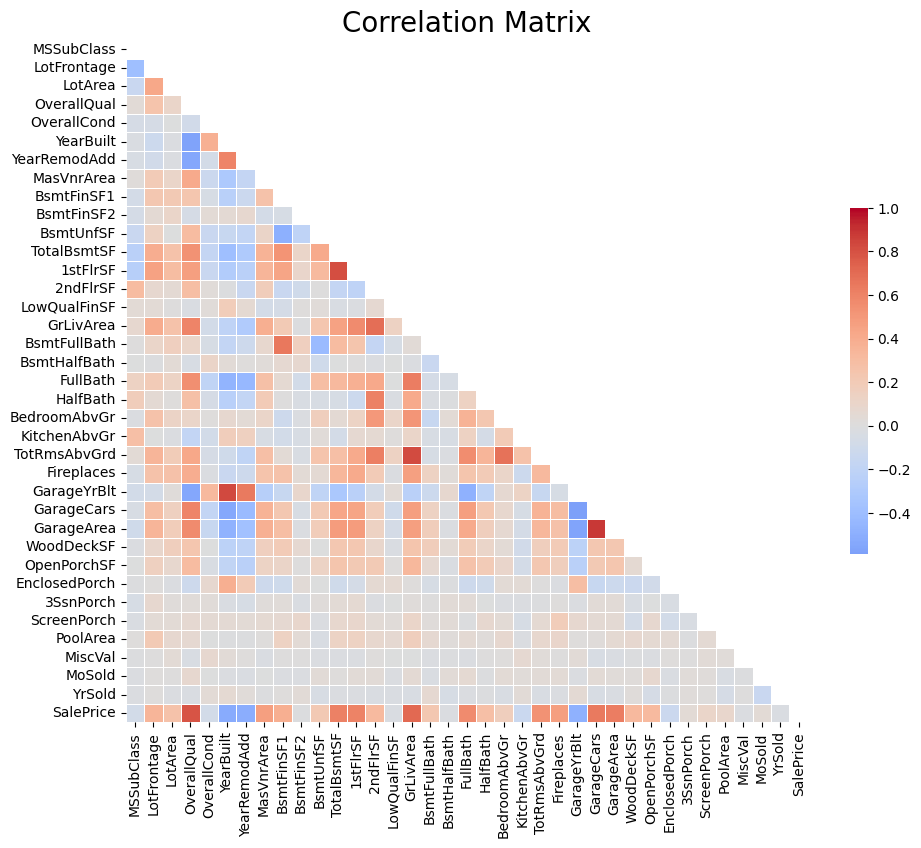

In [13]:
corr = df[numerical_features].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix', fontsize=20)
plt.show()

In [24]:
x = corr.where(np.triu(np.ones_like(corr, dtype=bool))).stack().reset_index()
x.columns = ['feature_1','feature_2', 'Correlation']
x = x[x.feature_1!=x.feature_2].sort_values('Correlation', ascending=False, key = lambda x: abs(x)).reset_index(drop=True)
x.head(10)

,feature_1,feature_2,Correlation
0,GarageCars,GarageArea,0.882475
1,YearBuilt,GarageYrBlt,0.826174
2,GrLivArea,TotRmsAbvGrd,0.825489
3,TotalBsmtSF,1stFlrSF,0.819530
4,OverallQual,SalePrice,0.790982
5,GrLivArea,SalePrice,0.708624
6,2ndFlrSF,GrLivArea,0.687501
7,BedroomAbvGr,TotRmsAbvGrd,0.676620
8,BsmtFinSF1,BsmtFullBath,0.649212
9,YearRemodAdd,GarageYrBlt,0.643039


In [33]:
x[ (x.feature_1=='SalePrice') | (x.feature_2=='SalePrice')].reset_index(drop=True)

,feature_1,feature_2,Correlation
0,OverallQual,SalePrice,0.790982
1,GrLivArea,SalePrice,0.708624
2,GarageCars,SalePrice,0.640409
3,GarageArea,SalePrice,0.623431
4,TotalBsmtSF,SalePrice,0.613581
5,1stFlrSF,SalePrice,0.605852
6,FullBath,SalePrice,0.560664
7,TotRmsAbvGrd,SalePrice,0.533723
8,YearBuilt,SalePrice,-0.523350
9,YearRemodAdd,SalePrice,-0.509079


In [ ]:
# features we want to remove
# for regression
option_1 = ['GarageCars', 'GarageYrBlt', 'TotRmsAbvGrd']

###
must_removed = [ 'TotalBsmtSF', 'GrLivArea', ]

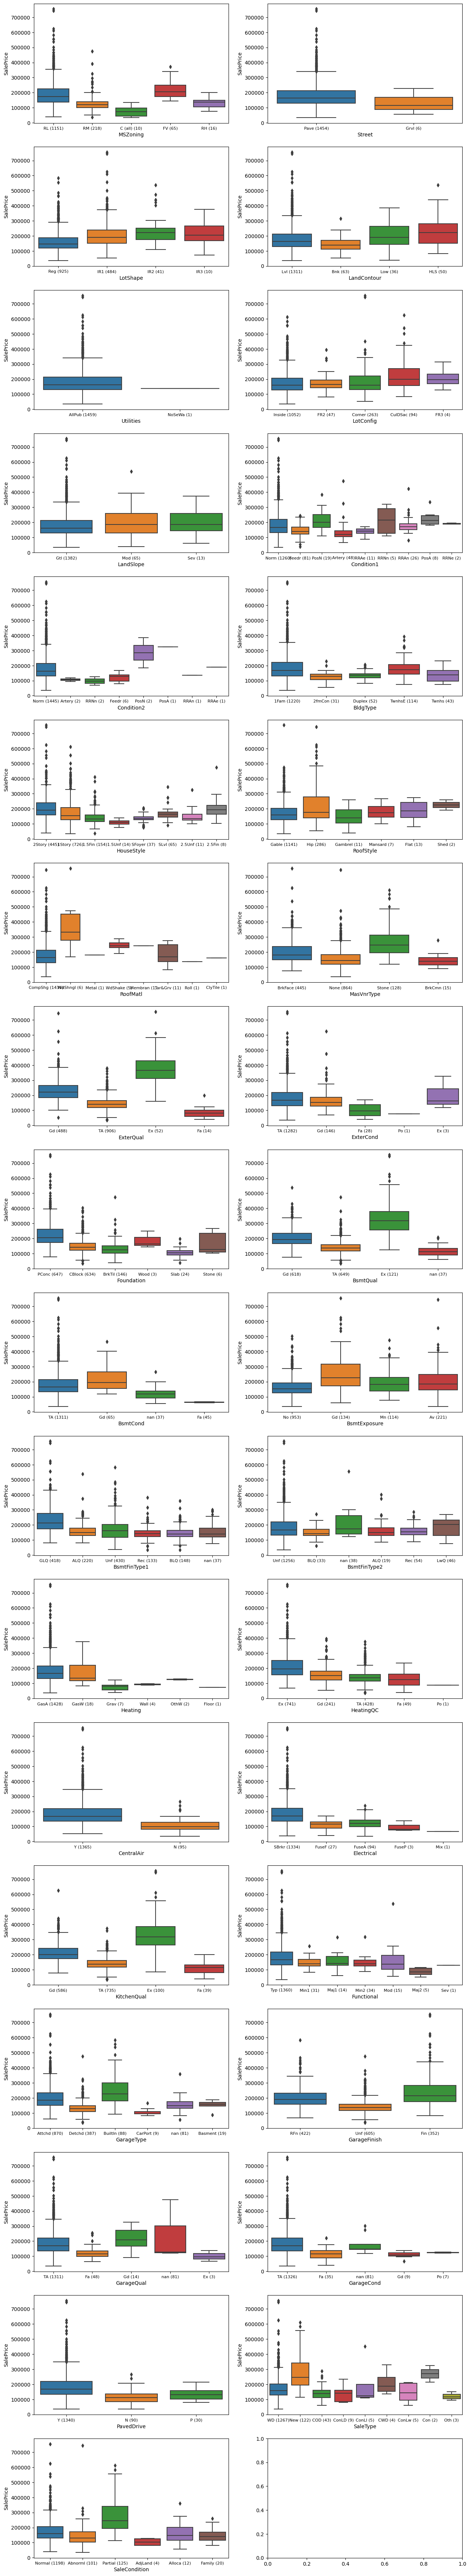

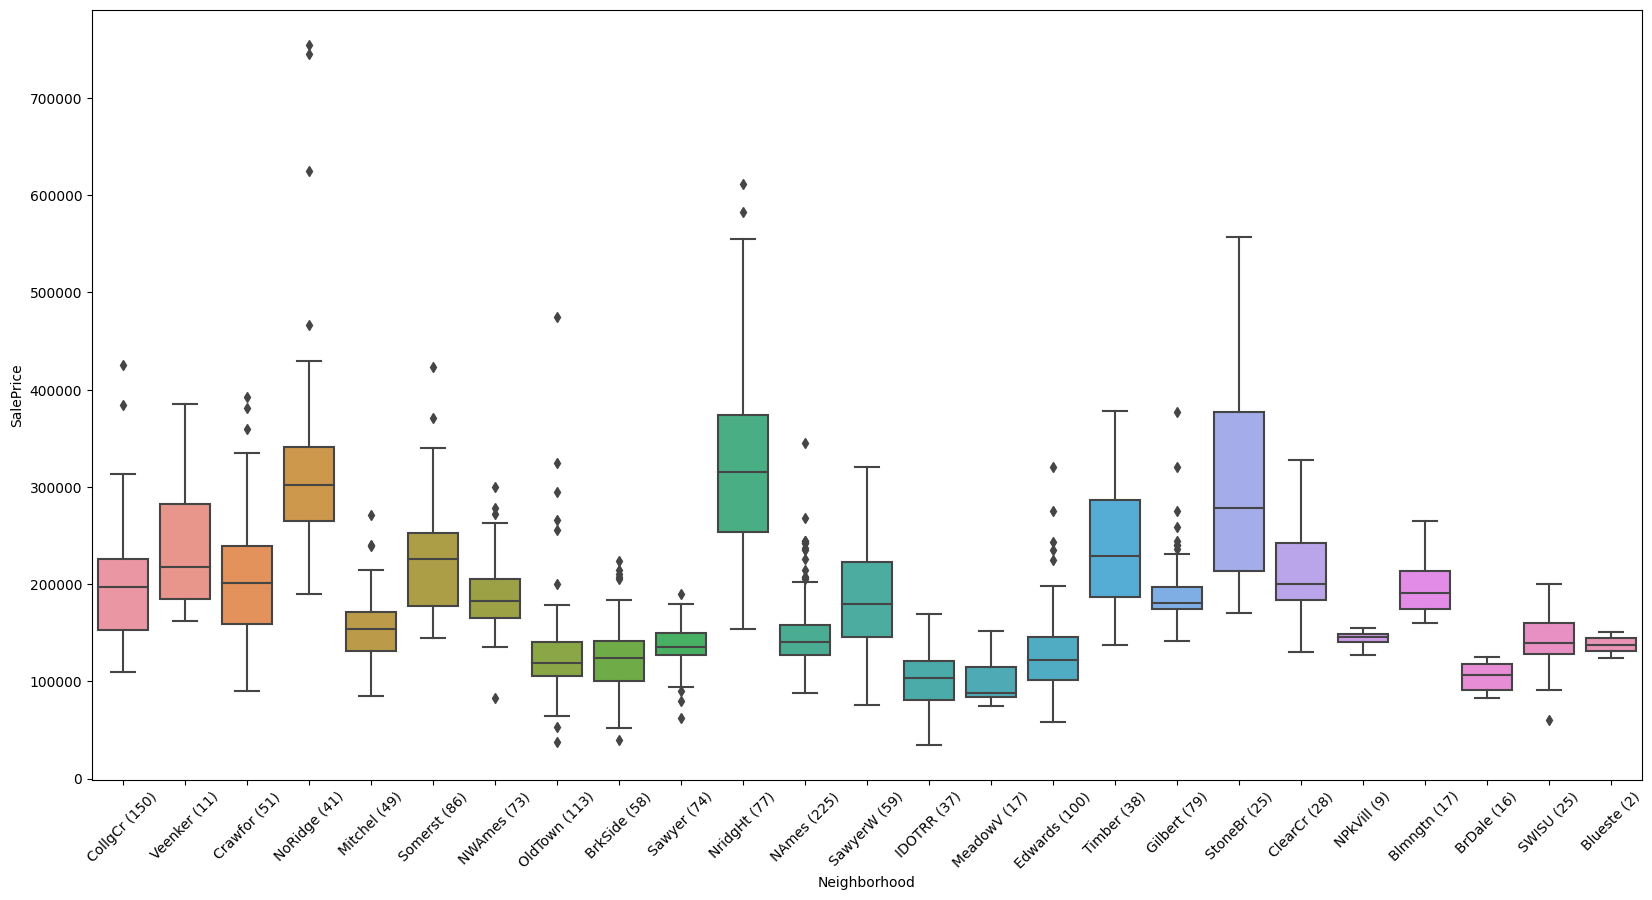

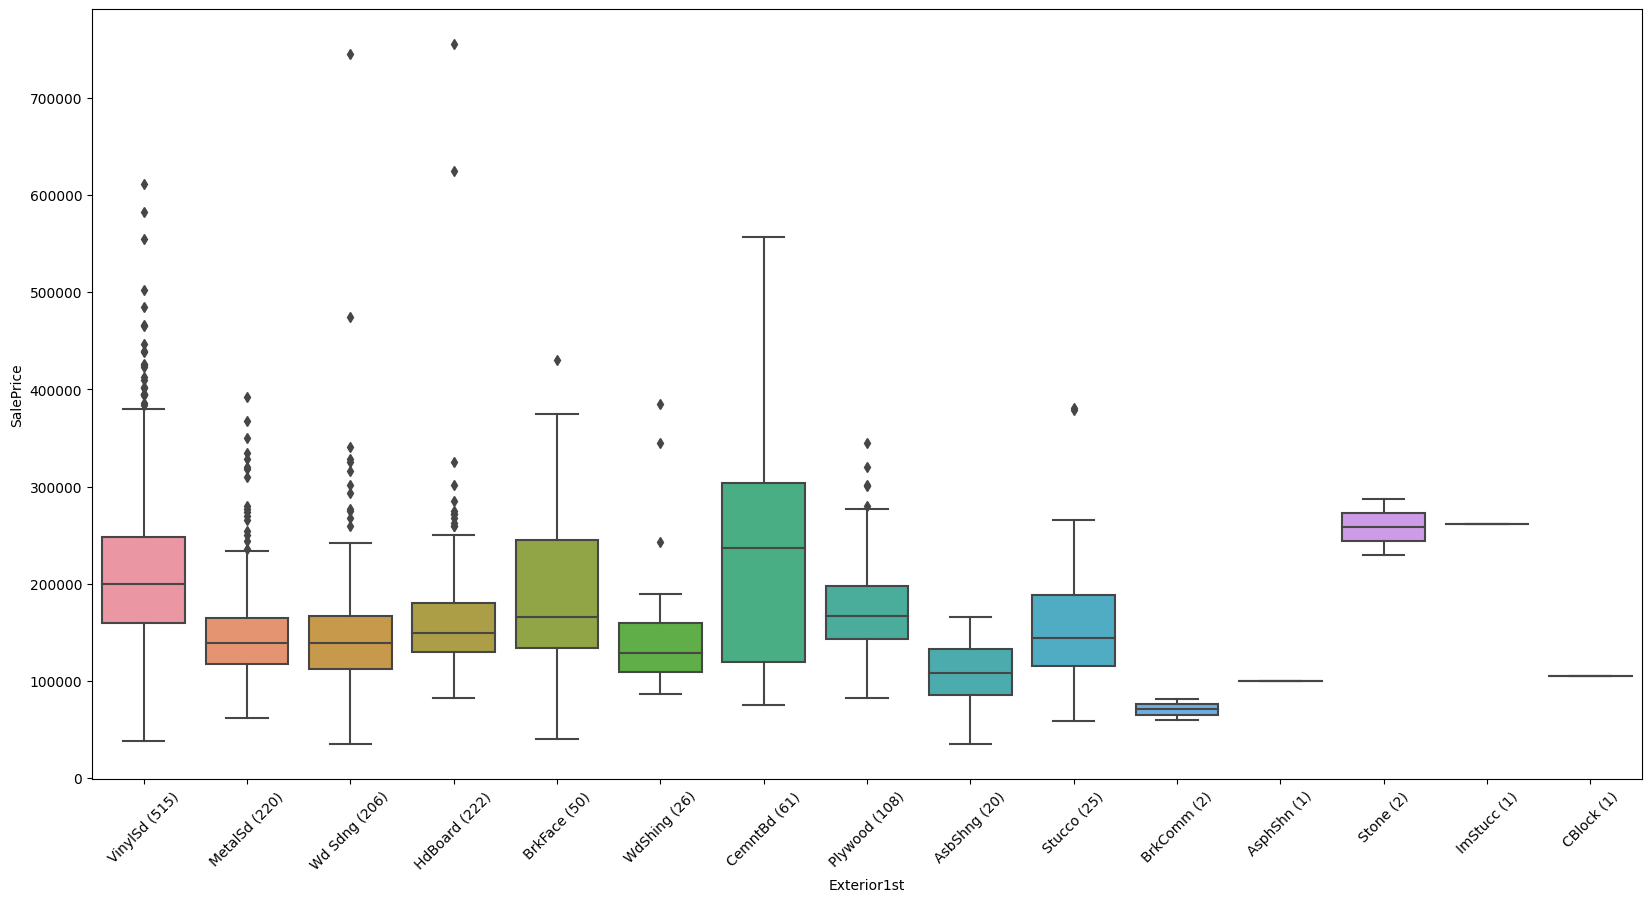

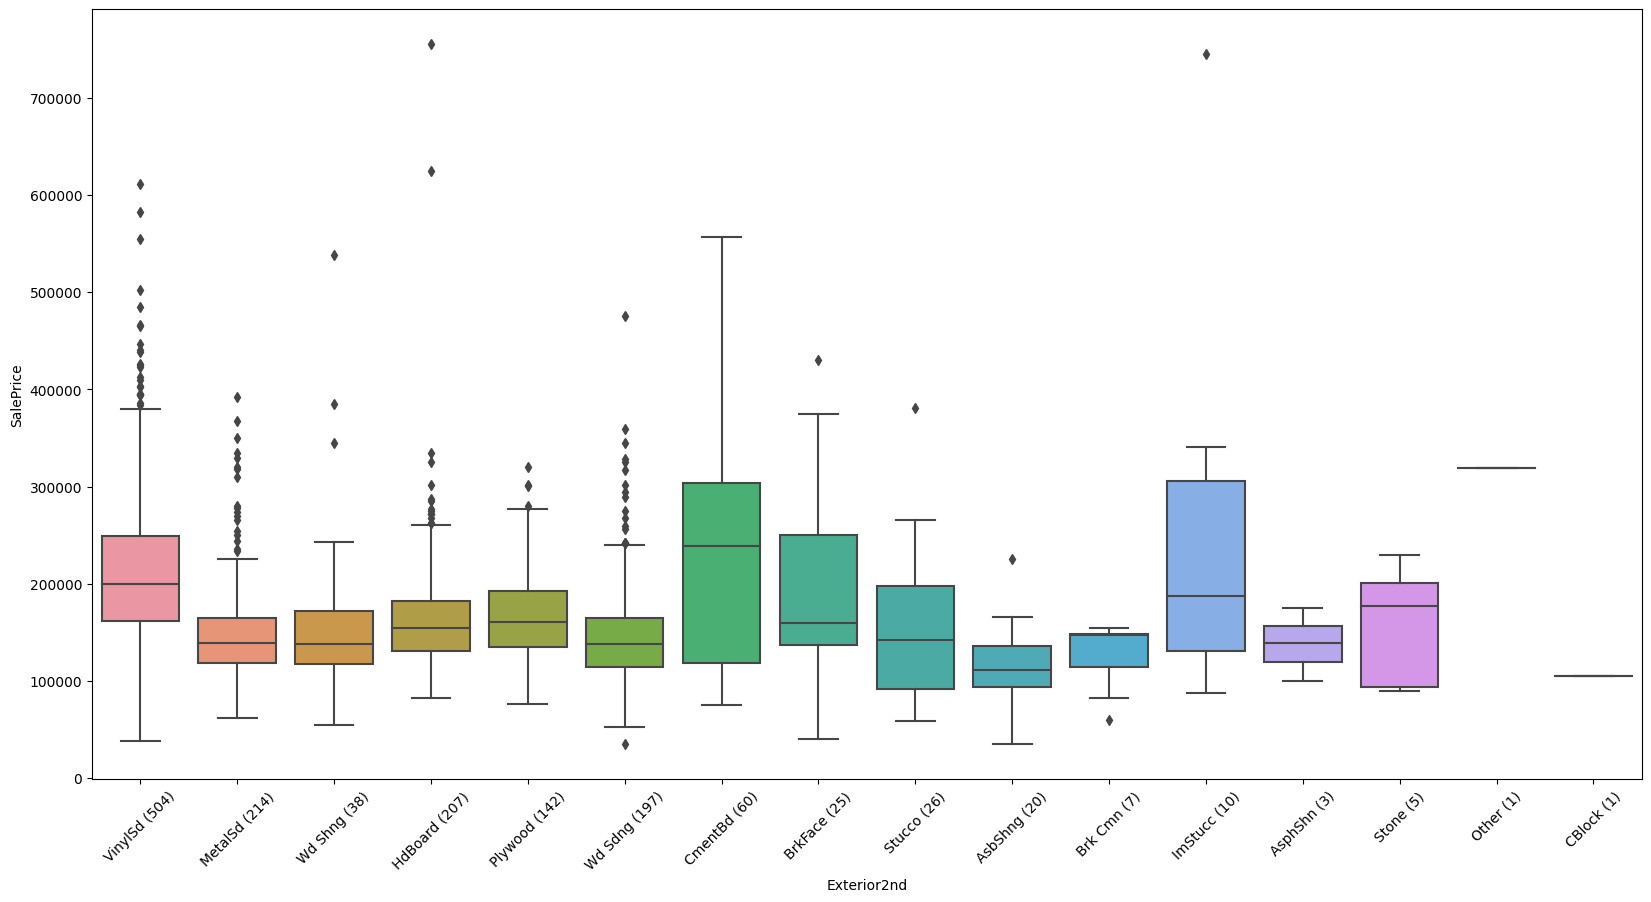

In [50]:
# Defining the number of rows and columns for subplot grid
# Remove 2 from the total because we are plotting them separately due to labels not fitting
import math

n_rows = math.ceil((len(categorical_features) -2) / 2)
n_cols = 2

# Create a figure and a grid of subplots
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows*5))

# List of columns to plot separately
large_plot_cols = ['Neighborhood', 'Exterior1st', 'Exterior2nd']

# Plotting grid subplots
i = 0
for cat_col in categorical_features:
    if cat_col not in large_plot_cols:
        row = i // n_cols
        col = i % n_cols
        sns.boxplot(x=df[cat_col], y=df['SalePrice'], ax=ax[row, col])
        labels = ['{} ({})'.format(label, df[cat_col].tolist().count(label)) for label in df[cat_col].unique()]
        ax[row, col].set_xticklabels(labels[:len(ax[row, col].get_xticks())], fontsize=8)
        i += 1

# Plotting separate larger plots
for cat_col in large_plot_cols:
    plt.figure(figsize=(20, 10))
    sns.boxplot(x=df[cat_col], y=df['SalePrice'])
    plt.xticks(rotation=45)  # Rotate x labels for better visibility
    labels = ['{} ({})'.format(label, df[cat_col].tolist().count(label)) for label in df[cat_col].unique()]
    plt.gca().set_xticklabels(labels[:len(plt.gca().get_xticks())])
    plt.show()

In [ ]:
'Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating'

In [ ]:
 'Alley', 'PoolQC', 'Fence', 'MiscFeature',

In [74]:
d = {
    'feature': [],
    'attribute':[],
    'percentage':[],
}
for i in categorical_features:
     x1, x2 = max([ (df[i].tolist().count(label)/len(df), label) for label in df[i].unique()])
     d['feature'].append(i)
     d['attribute'].append(x2)
     d['percentage'].append(x1)
pd.DataFrame(d).query('percentage > .95')

,feature,attribute,percentage
1,Street,Pave,0.995890
4,Utilities,AllPub,0.999315
9,Condition2,Norm,0.989726
13,RoofMatl,CompShg,0.982192
25,Heating,GasA,0.978082


In [72]:
df['Miley'] = ((df['Alley'].notna()) | (df['MiscFeature'].notna())).astype(int)
# Dropping 'Alley' and 'MiscFeature'
df.drop(columns=['Alley', 'MiscFeature'], inplace=True)
df['LotFrontage'].fillna(df['LotFrontage'].median(), inplace=True)


df.drop(['GarageType', 'GarageFinish', 'GarageCond'], axis=1, inplace=True)

# Fill missing values in 'GarageQual' with 'None'
df['GarageQual'].fillna('None', inplace=True)





df.drop(['BsmtFinType2', 'BsmtExposure', 'BsmtCond', 'BsmtFinType1'], axis=1, inplace=True)

# Fill missing values in 'GarageQual' with 'None'
df['BsmtQual'].fillna('None', inplace=True)

# Fill missing values in 'MasVnrType' with 'None'
df['MasVnrType'].fillna('None', inplace=True)
# Fill missing values in 'MasVnrArea' with 0
df['MasVnrArea'].fillna(0, inplace=True)

38

In [1]:
 i = 'Street'
 max([(df[i].tolist().count(label), label) for label in df[i].unique()])

NameError: ignored

In [65]:
df['Exterior2nd'].value_counts()

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

In [ ]:
pd.DataFrame(df.isnull().sum(), columns = ["count_null"]).query('count_null > 0')

,count_null


In [ ]:
# seggregating categorical and numerical features

df_numerical_features = df.select_dtypes(exclude='object')
df_categorical_features = df.select_dtypes(include='object')

In [ ]:
# number of unique values for each categorical features
for i in categorical_features[:5]:
  print(i, ":", df_categorical_features[i].nunique())

In [ ]:
categorical_mapper = {}
for i in categorical_features:
  categorical_mapper[i] = dict(df.groupby(i)['SalePrice'].mean())
  df[i] = df.groupby(i)['SalePrice'].transform('mean')
  if 'Not present' not in categorical_mapper[i].keys():
    categorical_mapper[i]['Not present'] = df['SalePrice'].mean()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
scaler_X, scaler_Y = MinMaxScaler(), MinMaxScaler()

In [ ]:
y = df[['SalePrice']]
X = df.drop('SalePrice',axis=1)
cols = X.columns

In [ ]:
X, y = scaler_X.fit_transform(X), scaler_Y.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(1168, 78)

In [ ]:
y_train.shape

(1168, 1)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
lr.score(X_train, y_train)

0.8751860400650017

In [ ]:
lr.score(X_test, y_test)

0.8743394892316343

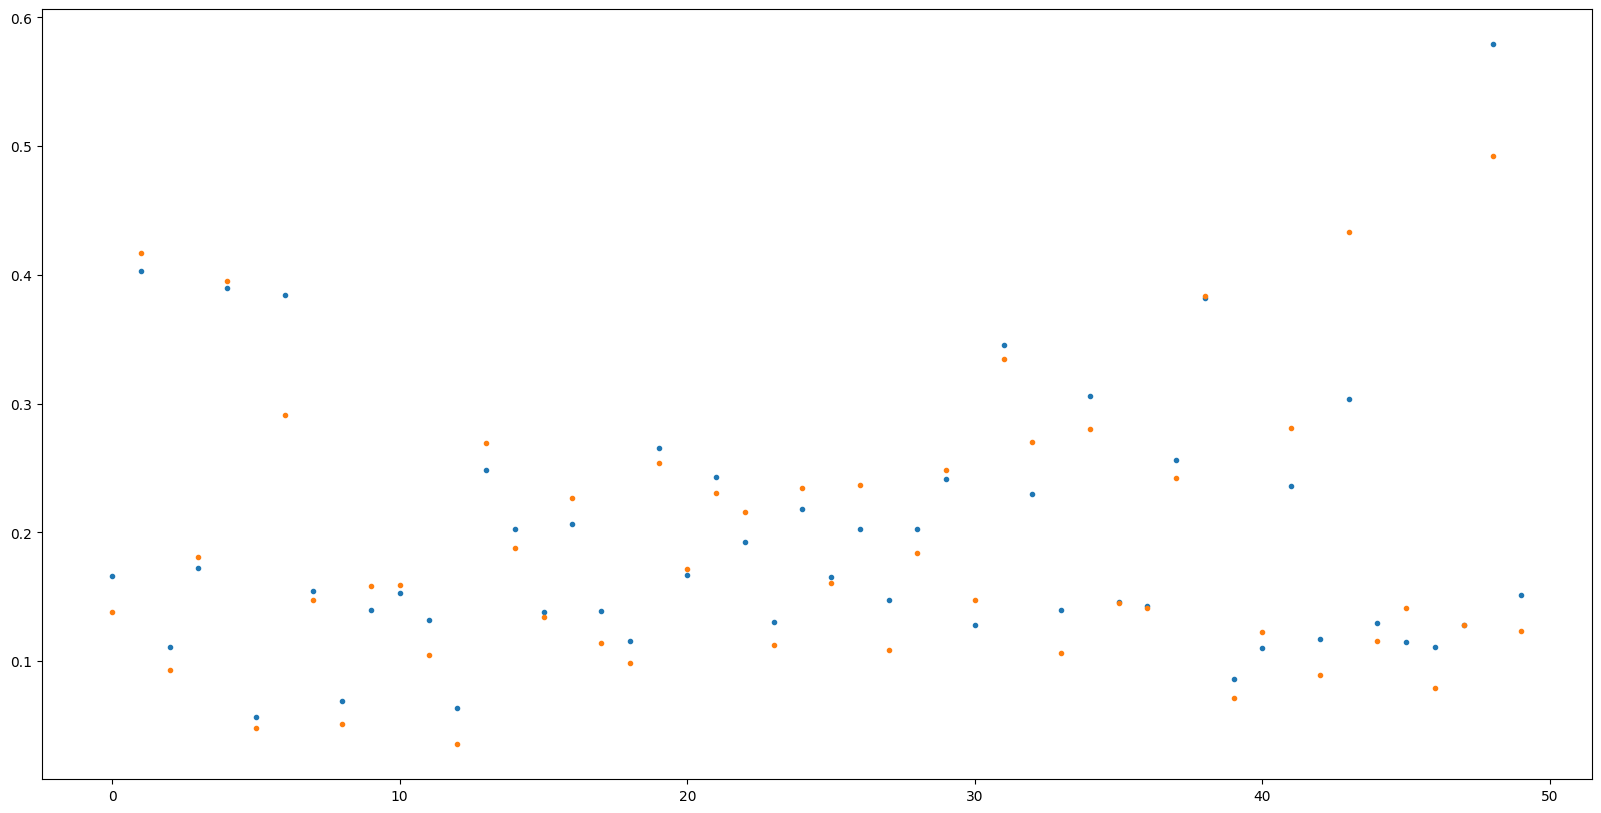

In [ ]:
p=50
plt.figure(figsize=(20,10))
plt.plot(np.arange(X_test.shape[0])[:p], y_test[:p], '.', label= 'actual')
plt.plot(np.arange(X_test.shape[0])[:p], lr.predict(X_test)[:p],'.', label= 'predicted')
plt.show()

In [ ]:
pd.DataFrame(zip(cols,lr.coef_.flatten()), columns= ['feature_name', 'weight']
             ).sort_values('weight', ascending=False, key= lambda x: abs(x))

,feature_name,weight
37,TotalBsmtSF,7.586493e+11
33,BsmtFinSF1,-7.007883e+11
45,GrLivArea,-6.769959e+11
42,1stFlrSF,5.558305e+11
36,BsmtUnfSF,-2.900499e+11
...,...,...
40,CentralAir,1.366092e-03
27,ExterCond,-1.198823e-03
64,PavedDrive,4.844385e-04
56,FireplaceQu,4.206081e-04


In [ ]:
test_data = pd.read_csv('test.csv')
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [ ]:
test_df = test_data.drop('Id', axis=1)

In [ ]:
calc_cols = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
for i in calc_cols:
  test_df[i] = test_df['YrSold'] - test_df[i]


In [ ]:
test_df = test_df.drop(droping_cols, axis=1).fillna(value= mapper_na_to_val)

{'1Fam': 185763.80737704918,
 '2fmCon': 128432.25806451614,
 'Duplex': 133541.07692307694,
 'Twnhs': 135911.62790697673,
 'TwnhsE': 181959.34210526315,
 'c': 1}

In [ ]:
categorical_mapper

In [ ]:
test_df.replace(categorical_mapper,inplace=True)

In [ ]:
test_df[categorical_features].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,131558.375,181130.538514,183452.131483,164754.818378,180183.746758,180950.95682,176938.047529,179956.799566,145847.080000,142475.481481,...,202892.656322,142156.423140,187489.836003,187885.735294,186433.973881,180404.663455,148751.089172,182046.410384,173401.836622,175202.219533
1,191004.994787,181130.538514,183452.131483,206101.665289,180183.746758,180950.95682,181623.425856,179956.799566,145847.080000,184495.492063,...,202892.656322,142156.423140,187489.836003,187885.735294,186433.973881,180404.663455,187596.837998,170750.000000,173401.836622,175202.219533
2,191004.994787,181130.538514,183452.131483,206101.665289,180183.746758,180950.95682,176938.047529,179956.799566,192854.506329,184495.492063,...,202892.656322,240052.690341,187489.836003,187885.735294,186433.973881,180404.663455,148751.089172,182046.410384,173401.836622,175202.219533
3,191004.994787,181130.538514,183452.131483,206101.665289,180183.746758,180950.95682,176938.047529,179956.799566,192854.506329,184495.492063,...,202892.656322,240052.690341,187489.836003,187885.735294,186433.973881,180404.663455,187596.837998,182046.410384,173401.836622,175202.219533
4,191004.994787,181130.538514,183452.131483,206101.665289,231533.940000,180950.95682,176938.047529,179956.799566,310499.000000,184495.492063,...,202892.656322,202068.869668,187489.836003,187885.735294,186433.973881,180404.663455,187596.837998,182046.410384,173401.836622,175202.219533


In [ ]:
test_df.info()

In [ ]:
test_df['SalePrice']=scaler_Y.inverse_transform(lr.predict(scaler_X.transform(test_df)))


In [ ]:
x = pd.DataFrame()
x['Id'] = test_data['Id']
x['SalePrice'] = test_df['SalePrice']
x.to_csv('output.csv',index=False)

In [56]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f output.csv -m "GRB model"

100% 33.7k/33.7k [00:00<00:00, 45.7kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

In [ ]:
# !pip install --upgrade gupload

# from pydrive.auth import GoogleAuth
# from google.colab import auth

# # Authenticate and create the PyDrive client.
# auth.authenticate_user()

# !gupload --to '176S28FbPajpGb1WXrWZxB0WPM5V23ol9' train.csv